## Разработать модель(и) машинного обучения для прогнозирования ежедневного GMV (Gross Merchandise Value) и количества заказов на 7 дней вперед. Оценка качества прогнозов на основе MAPE

## Что нужно сделать:
* Исследовательский анализ данных (EDA).
* Подготовка данных и генерация признаков (Feature Engineering).
* Выбор и обучение модели.
* Оценка качества прогнозов.

### Исследовательский анализ данных (EDA)

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.seasonal import MSTL

In [2]:
df = pd.read_csv('../data/daily_sales_metrics.csv', parse_dates=['date'])
df

,date,gmv,orders,sessions,marketing_spend,is_promo_active,day_of_week,day_of_year,week_of_year,month,year
0,2022-01-01,506994,1081,34861,25148,0,5,1,52,1,2022
1,2022-01-02,445834,819,32858,23769,0,6,2,52,1,2022
2,2022-01-03,348150,736,23081,22108,0,0,3,1,1,2022
3,2022-01-04,359418,872,25166,21757,0,1,4,1,1,2022
4,2022-01-05,381439,871,31082,21420,0,2,5,1,1,2022
...,...,...,...,...,...,...,...,...,...,...,...
1090,2024-12-26,891794,5410,171515,54332,0,3,361,52,12,2024
1091,2024-12-27,1011484,6330,219724,55346,0,4,362,52,12,2024
1092,2024-12-28,1064332,6767,229631,56839,0,5,363,52,12,2024
1093,2024-12-29,1150266,6829,223812,75393,1,6,364,52,12,2024


## Проверим типы и целостность данных

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             1095 non-null   datetime64[ns]
 1   gmv              1095 non-null   int64         
 2   orders           1095 non-null   int64         
 3   sessions         1095 non-null   int64         
 4   marketing_spend  1095 non-null   int64         
 5   is_promo_active  1095 non-null   int64         
 6   day_of_week      1095 non-null   int64         
 7   day_of_year      1095 non-null   int64         
 8   week_of_year     1095 non-null   int64         
 9   month            1095 non-null   int64         
 10  year             1095 non-null   int64         
dtypes: datetime64[ns](1), int64(10)
memory usage: 94.2 KB


In [4]:
df.isna().sum()

date               0
gmv                0
orders             0
sessions           0
marketing_spend    0
is_promo_active    0
day_of_week        0
day_of_year        0
week_of_year       0
month              0
year               0
dtype: int64

In [5]:
df.duplicated().sum()

np.int64(0)

## Из-за неопытности в работе с временными рядами только спустя день работы я узнал, что есть готовые модули для разложения ряда на тренды и сезонность. Я посмотрел, вроде результат тот же, что моими "ручными" методами. Если успею или результат будет плохой, переделаю по-человечески

## Построим графики для выявления сезонности

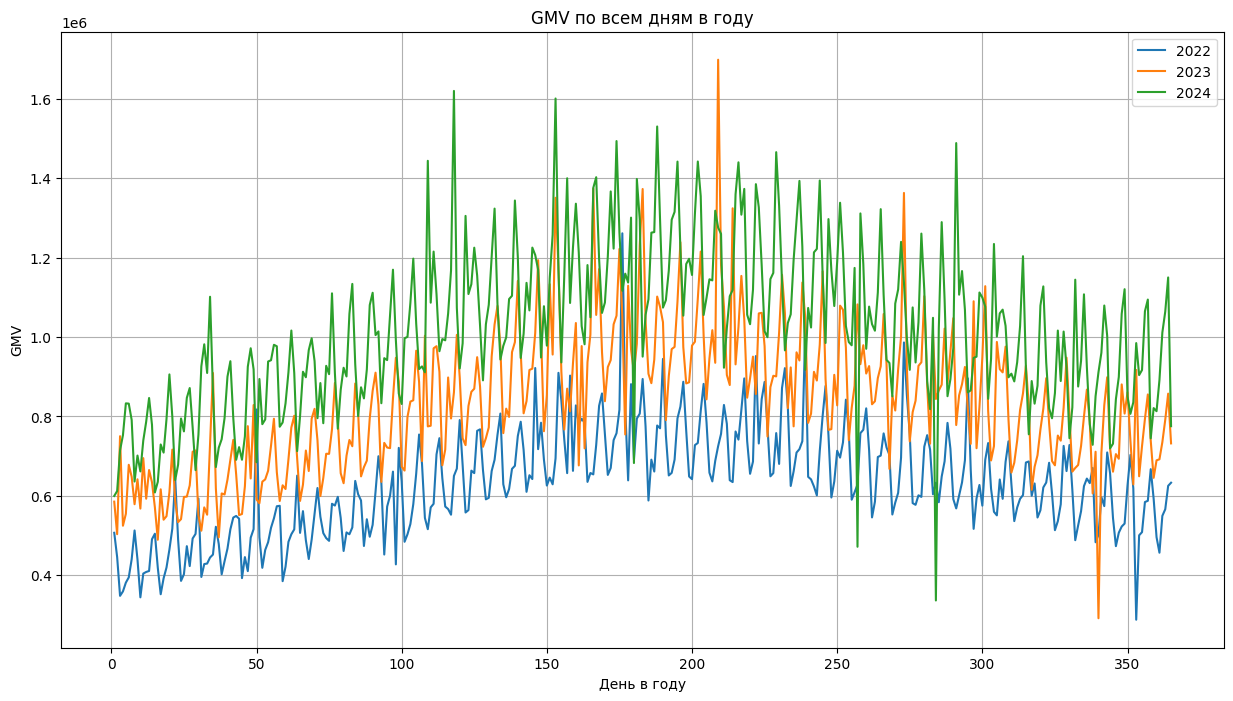

In [6]:
years = (2022, 2023, 2024)

plt.figure(figsize=(15, 8))

for year in years:
    sub = df[df.year == year]
    plt.plot(
        sub.day_of_year,
        sub.gmv,
        label=year
    )

plt.title('GMV по всем дням в году')
plt.xlabel('День в году')
plt.ylabel('GMV')
plt.legend()
plt.grid()
plt.show()

## С учётом крупных промо-акций

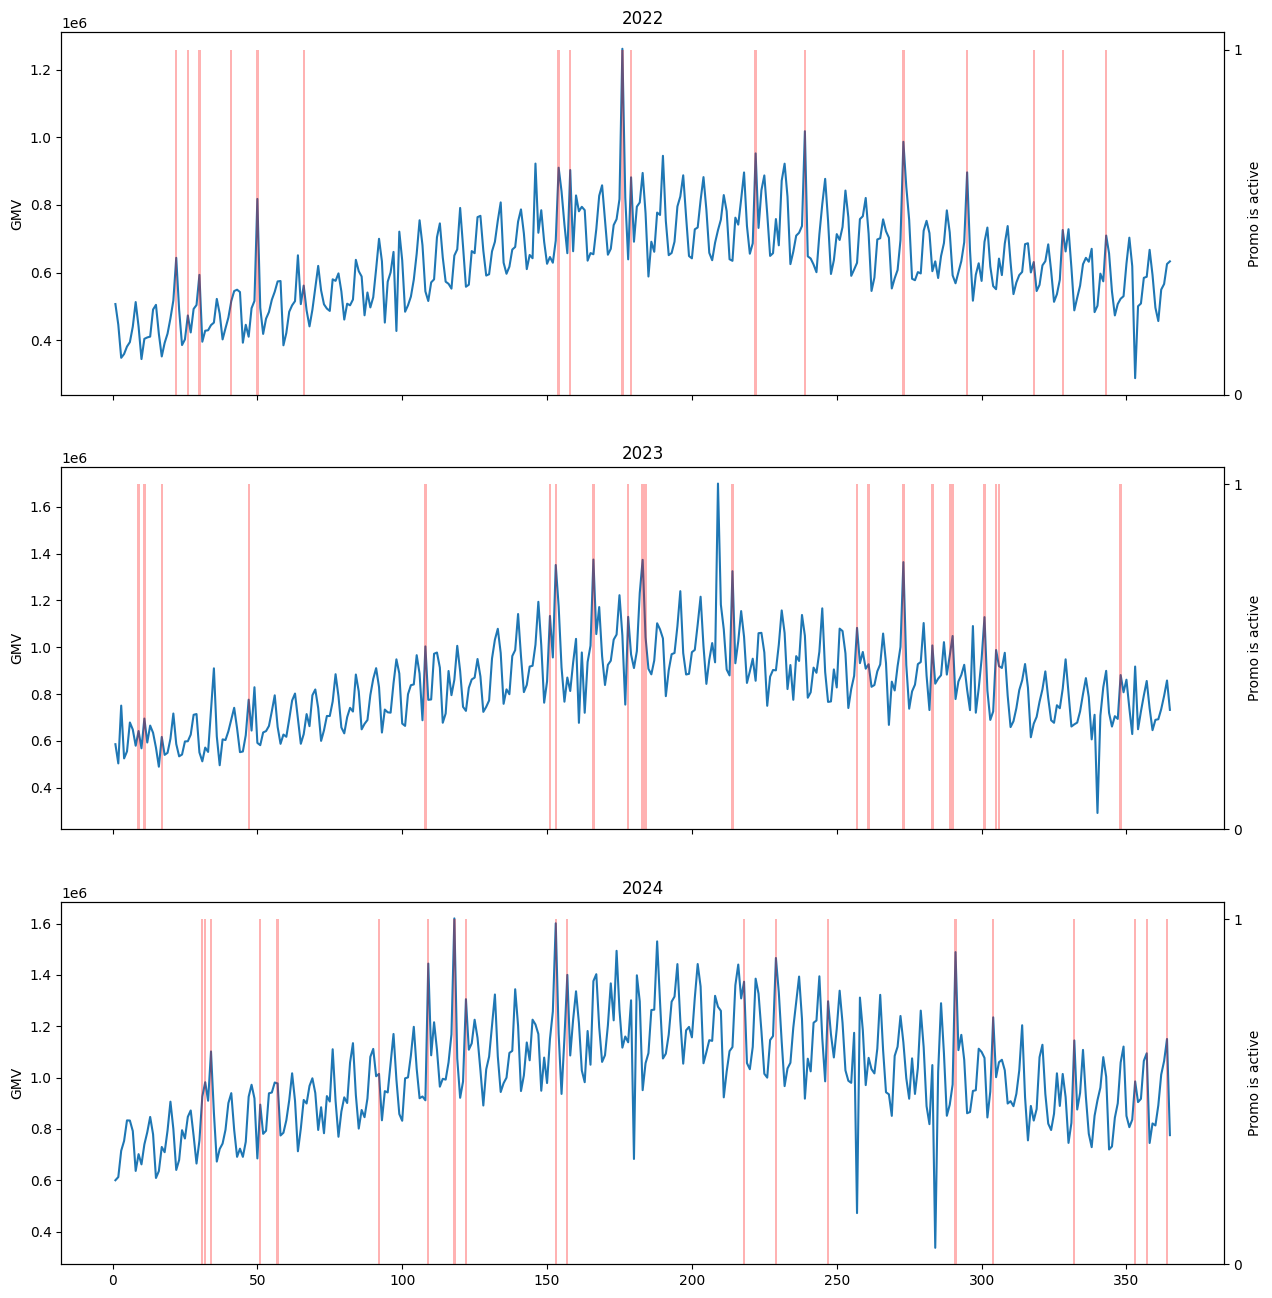

In [7]:
fig, axes = plt.subplots(3, 1, figsize=(15, 16), sharex=True)

for i, year in enumerate(years):
    ax = axes[i]
    sub = df[df.year == year]
    
    ax.plot(
        sub.day_of_year,
        sub.gmv,
    )
    ax.set_title(year)
    ax.set_ylabel('GMV')
    
    ax2 = ax.twinx()
    ax2.bar(
        sub.day_of_year,
        sub.is_promo_active,
        alpha=0.3,
        color='red',
    )
    ax2.set_ylabel('Promo is active')
    ax2.set_yticks([0, 1])

plt.xlabel('День в году')
plt.show()

## С учётом масштабов промо

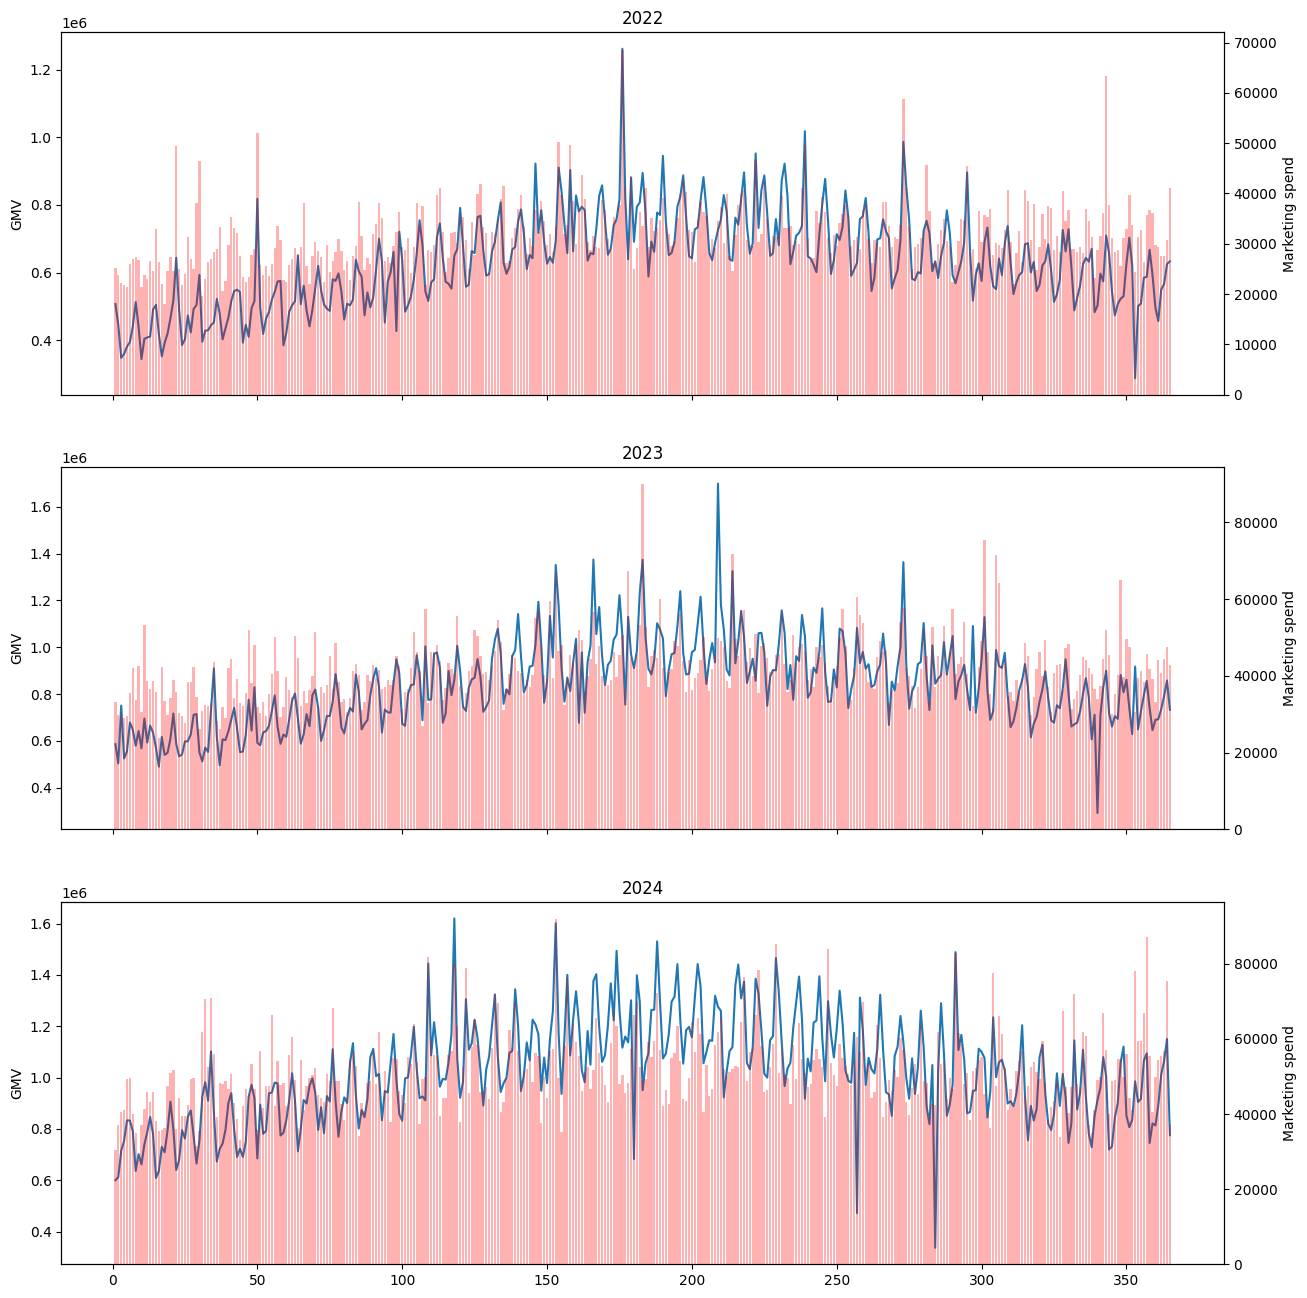

In [8]:
fig, axes = plt.subplots(3, 1, figsize=(15, 16), sharex=True)

for i, year in enumerate(years):
    ax = axes[i]
    sub = df[df.year == year]
    
    ax.plot(
        sub.day_of_year,
        sub.gmv,
    )
    ax.set_title(year)
    ax.set_ylabel('GMV')
    
    ax2 = ax.twinx()
    ax2.bar(
        sub.day_of_year,
        sub.marketing_spend,
        alpha=0.3,
        color='red',
    )
    ax2.set_ylabel('Marketing spend')

plt.xlabel('День в году')
plt.show()

### Похоже, что большие затраты на маркетинг в конкретныый день влияют только на этот день, потому что сразу после крупных по выручке и маркетингу дней идёт резкий спад, а не волна повышенного спроса следующие несколько дней после крупной рекламы. По этой причине учитывать в качестве признаков масштаб маркетинговой кампании за прошлые несколько дней мы не будем

In [221]:
test_df = df.copy()

mstl = MSTL(test_df['gmv'], periods=[7, 365])
res = mstl.fit()

test_df['residual'] = res.resid

q1 = test_df['residual'].quantile(0.25)
q3 = test_df['residual'].quantile(0.75)
iqr = q3 - q1

lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

test_df['is_outlier'] = (
    (test_df['residual'].lt(lower))
    | (test_df['residual'].gt(upper))
)

test_df['is_marketing_big'] = test_df['marketing_spend'] > test_df['marketing_spend'].quantile(0.75)

In [222]:
local = test_df['orders'].rolling(3, center=True).median()
pct_drop = (local - test_df['orders']) / local

test_df.loc[
    (test_df['is_outlier'] == True)     &
    (test_df['is_promo_active'] == 0)   &
    (test_df['is_marketing_big'] == 0)  |
    (pct_drop > 0.1),
    'gmv'
] = test_df['gmv'].rolling(7, center=True).median()

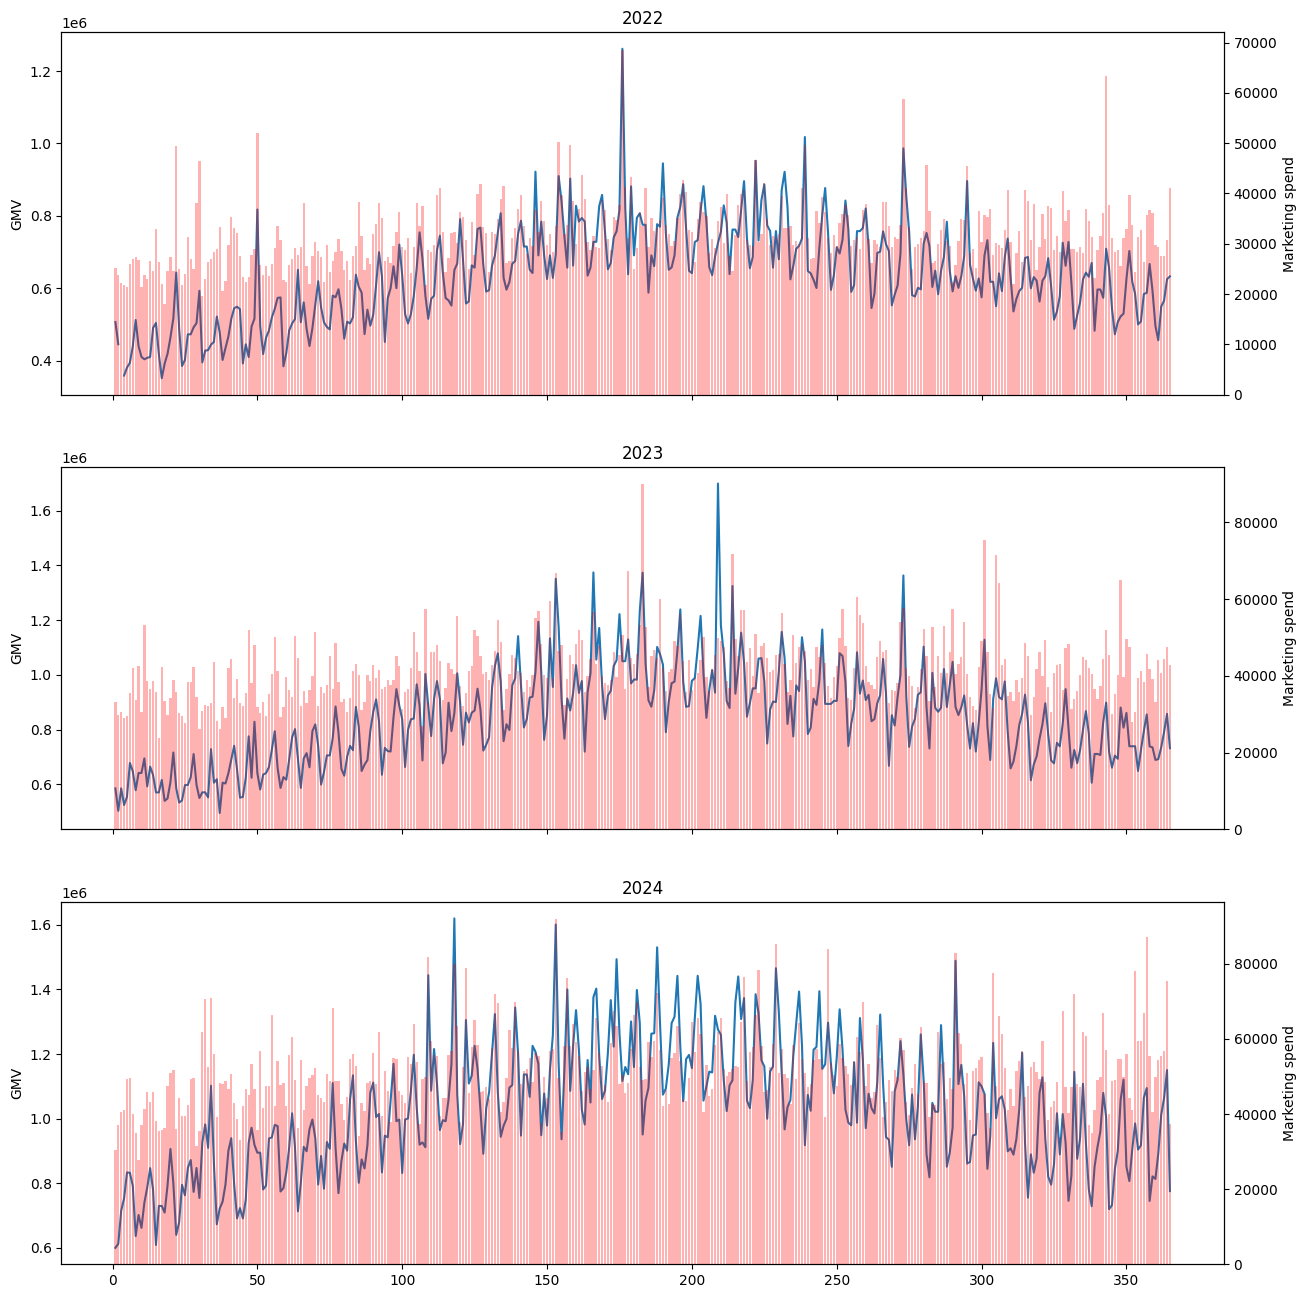

In [223]:
fig, axes = plt.subplots(3, 1, figsize=(15, 16), sharex=True)

for i, year in enumerate(years):
    ax = axes[i]
    sub = test_df[test_df.year == year]
    
    ax.plot(
        sub.day_of_year,
        sub.gmv,
    )
    ax.set_title(year)
    ax.set_ylabel('GMV')
    
    ax2 = ax.twinx()
    ax2.bar(
        sub.day_of_year,
        sub.marketing_spend,
        alpha=0.3,
        color='red',
    )
    ax2.set_ylabel('Marketing spend')

plt.xlabel('День в году')
plt.show()

## Теперь для orders

In [227]:
mstl = MSTL(test_df['orders'], periods=[7, 365])
res = mstl.fit()

test_df['residual'] = res.resid

q1 = test_df['residual'].quantile(0.25)
q3 = test_df['residual'].quantile(0.75)
iqr = q3 - q1

lower = q1 - 1.3 * iqr
upper = q3 + 1.3 * iqr

test_df['is_outlier'] = (
    (test_df['residual'].lt(lower))
    | (test_df['residual'].gt(upper))
)

In [228]:
local = test_df['orders'].rolling(3, center=True).median()
pct_drop = (local - test_df['orders']) / local

test_df.loc[
    (test_df['is_outlier'] == True)     &
    (test_df['is_promo_active'] == 0)   &
    (test_df['is_marketing_big'] == 0)  |
    (pct_drop > 0.1),
    'orders'
] = test_df['orders'].rolling(7, center=True).median()

## Визуализируем количество заказов

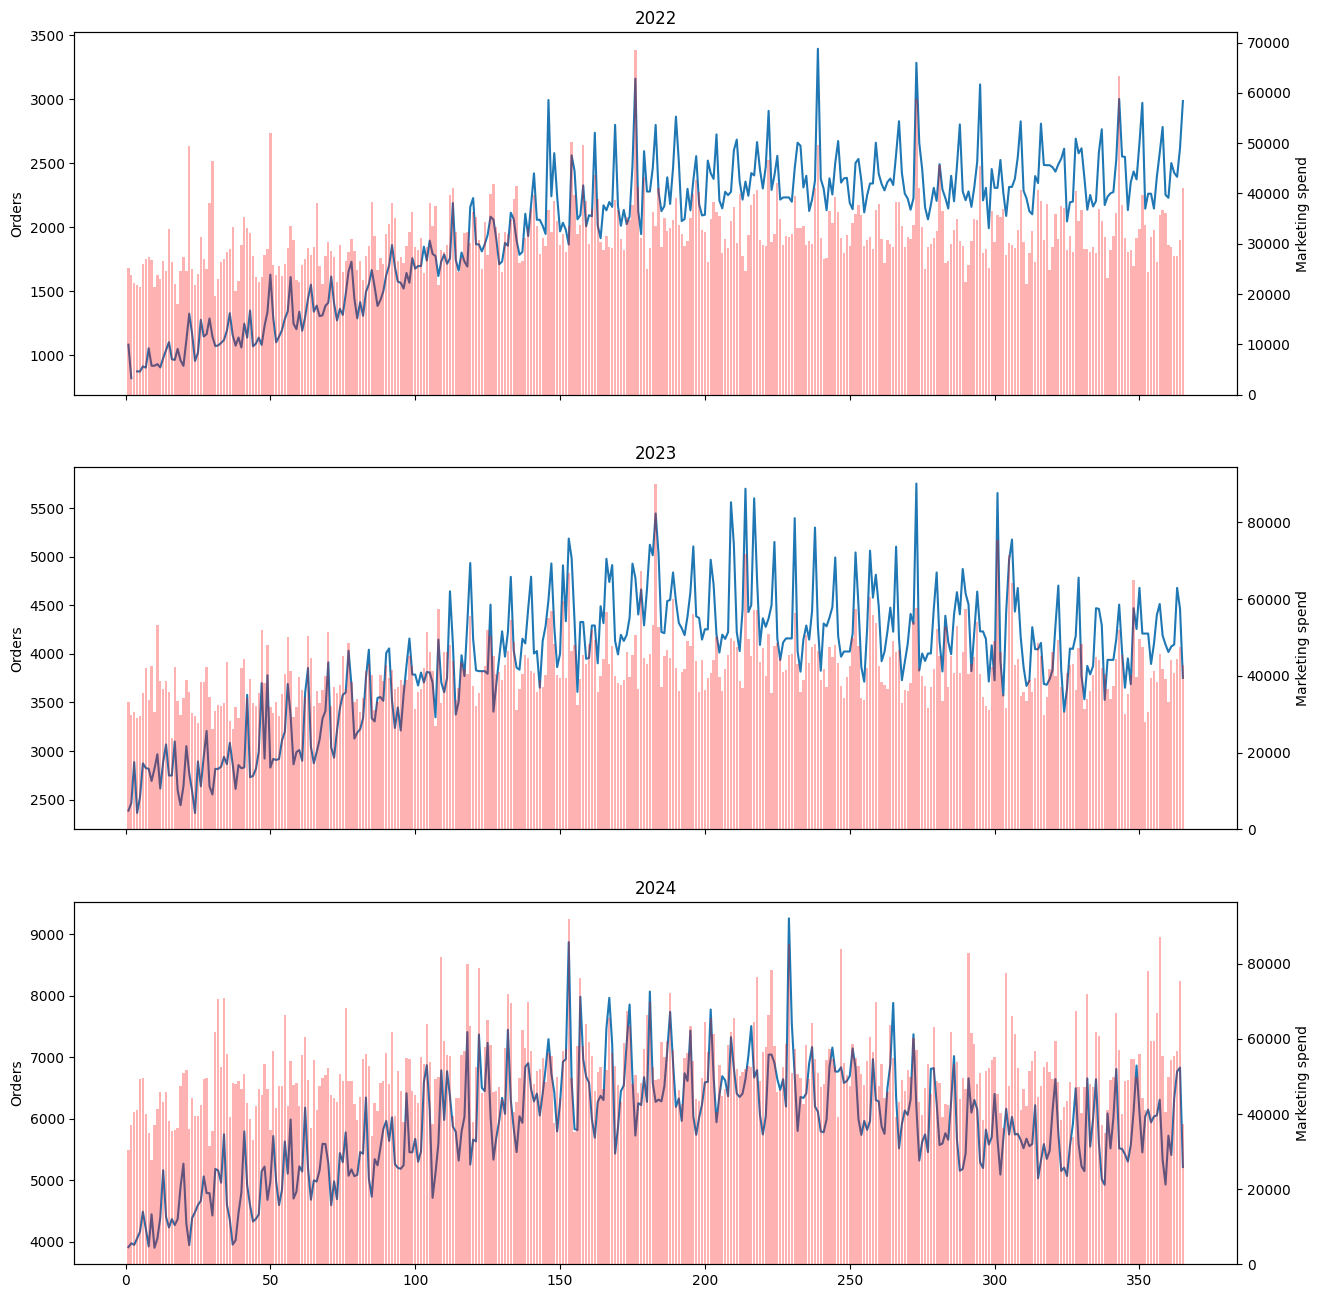

In [229]:
years = (2022, 2023, 2024)

fig, axes = plt.subplots(3, 1, figsize=(15, 16), sharex=True)

for i, year in enumerate(years):
    ax = axes[i]
    sub = test_df[test_df.year == year]
    
    ax.plot(
        sub.day_of_year,
        sub.orders,
    )
    ax.set_title(year)
    ax.set_ylabel('Orders')
    
    ax2 = ax.twinx()
    ax2.bar(
        sub.day_of_year,
        sub.marketing_spend,
        alpha=0.3,
        color='red',
    )
    ax2.set_ylabel('Marketing spend')

plt.xlabel('День в году')
plt.show()

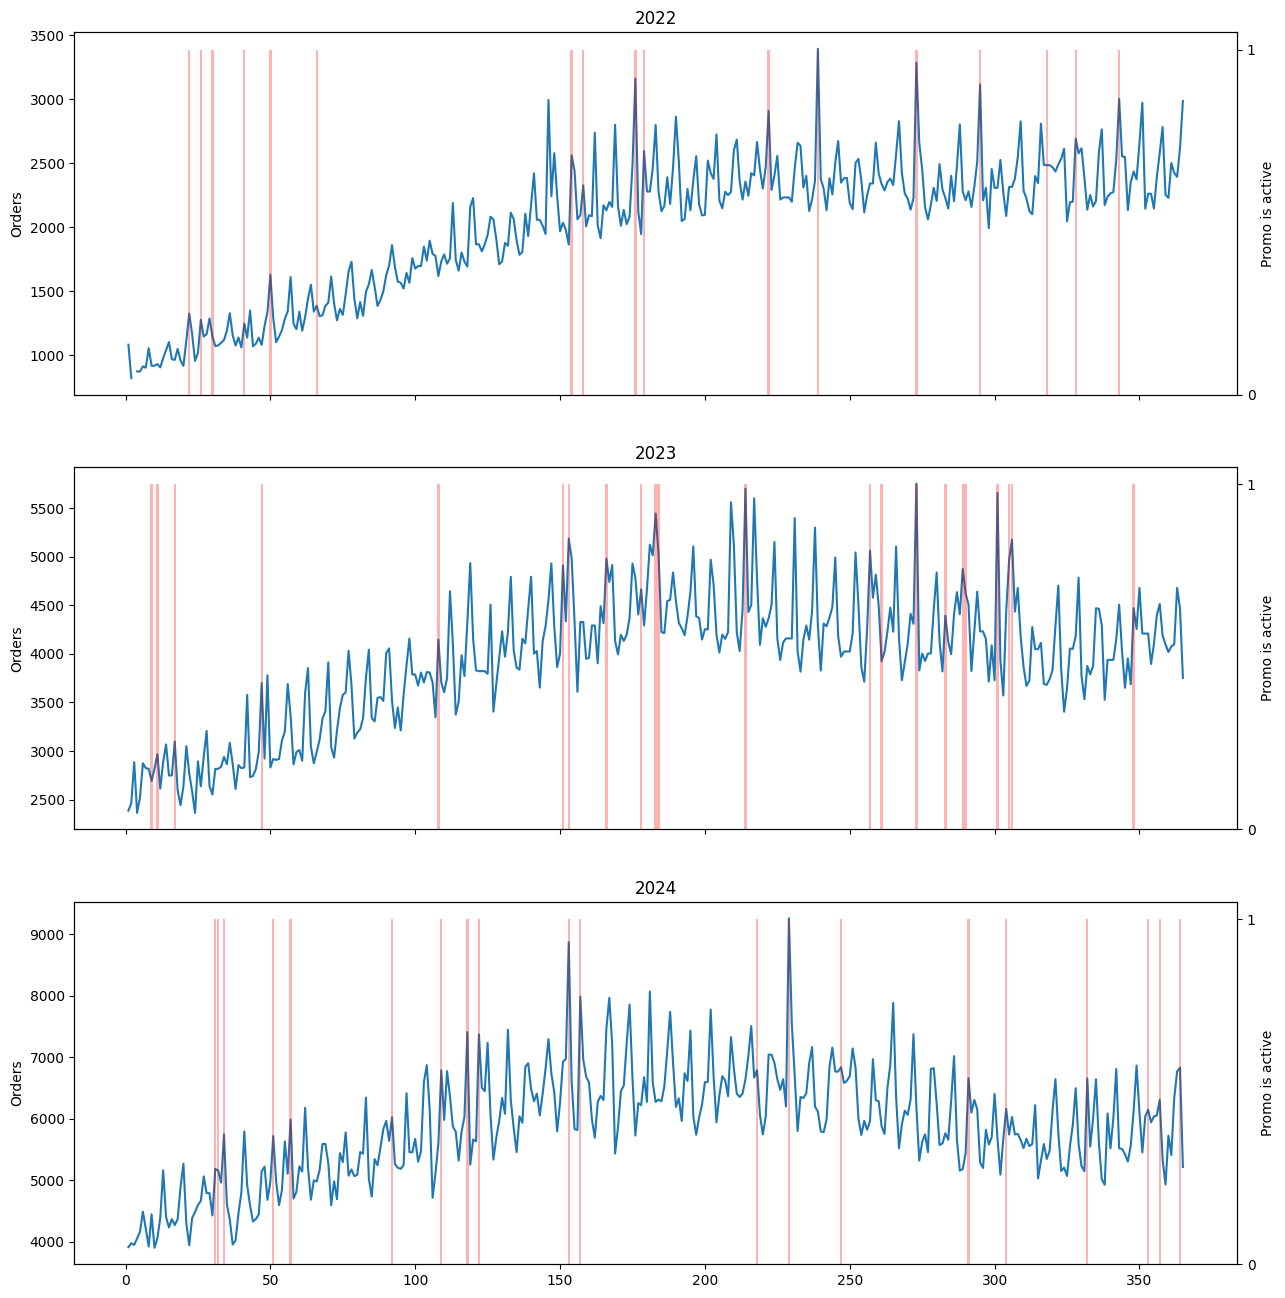

In [230]:
fig, axes = plt.subplots(3, 1, figsize=(15, 16), sharex=True)

for i, year in enumerate(years):
    ax = axes[i]
    sub = test_df[test_df.year == year]
    
    ax.plot(
        sub.day_of_year,
        sub.orders,
    )
    ax.set_title(year)
    ax.set_ylabel('Orders')
    
    ax2 = ax.twinx()
    ax2.bar(
        sub.day_of_year,
        sub.is_promo_active,
        alpha=0.3,
        color='red',
    )
    ax2.set_ylabel('Promo is active')
    ax2.set_yticks([0, 1])

plt.xlabel('День в году')
plt.show()

## Посмотрим, как себя показывают данные по дням недели

<Axes: xlabel='day_of_week', ylabel='orders'>

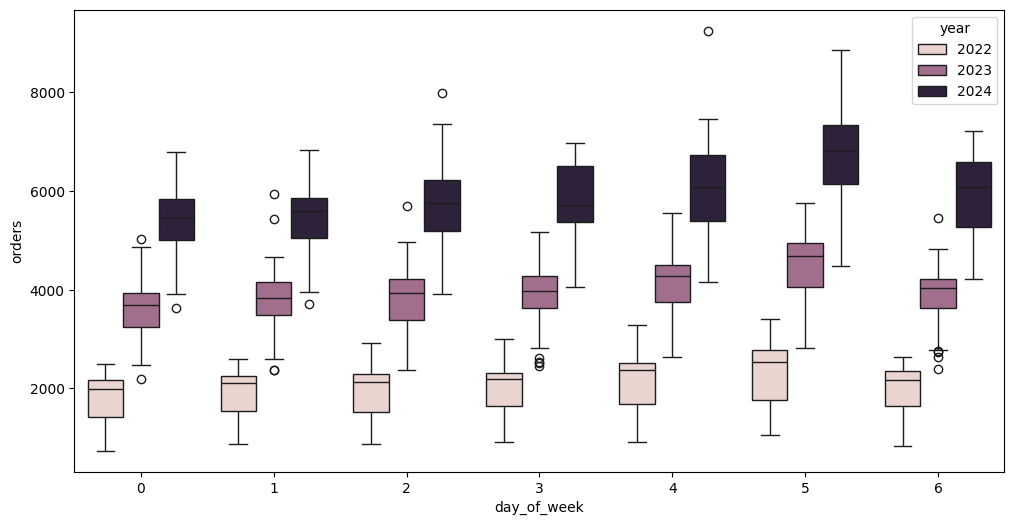

In [231]:
plt.figure(figsize=(12, 6))

sns.boxplot(
    data=df,
    x='day_of_week',
    y='orders',
    hue='year'
)

## Заметим сезонность внутри мессяца

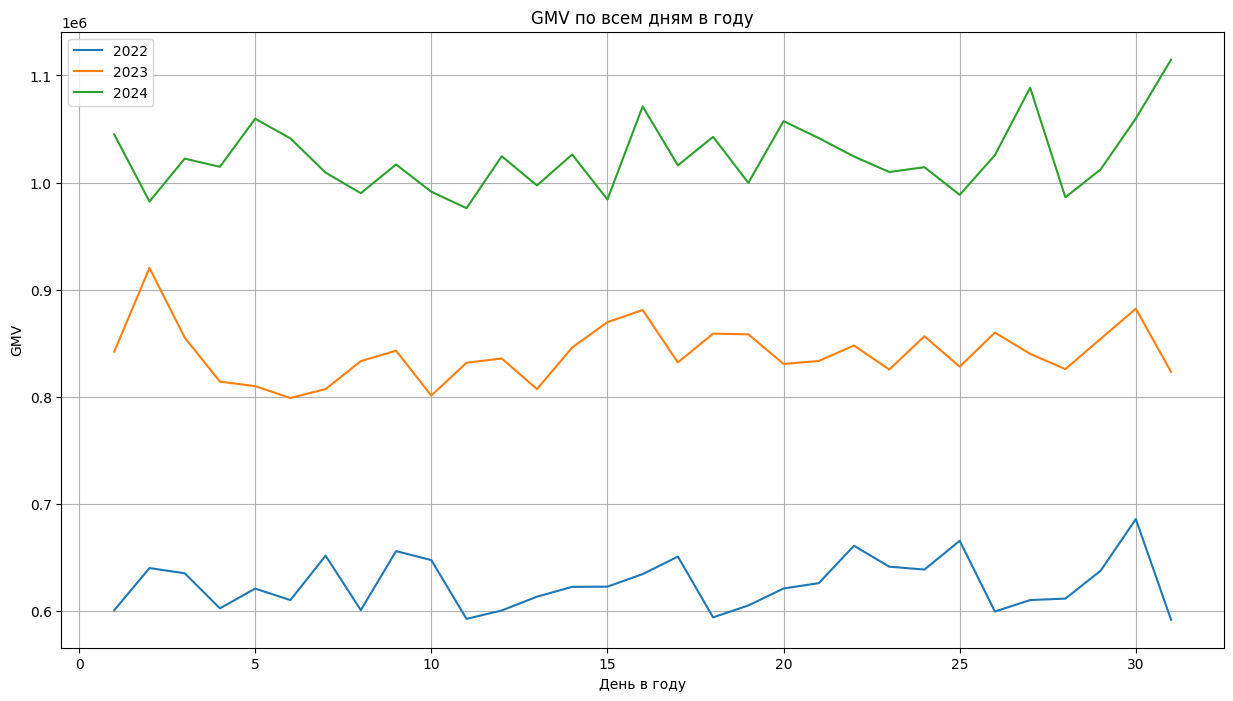

In [28]:
df.set_index('date', inplace=True)

years = (2022, 2023, 2024)

plt.figure(figsize=(15, 8))

sub = df.copy()
sub['day_of_month'] = sub.index.day
sub = sub.groupby(['year', 'day_of_month'])['gmv'].mean().reset_index(level=[0, 1])

for year in years:
    sub_year = sub[sub['year'] == year]
    plt.plot(
        sub_year.day_of_month,
        sub_year.gmv,
        label=year
    )

plt.title('GMV по всем дням в году')
plt.xlabel('День в году')
plt.ylabel('GMV')
plt.legend()
plt.grid()
plt.show()

### Есть паттерн, как минимум, в виде пиков в начале, середине и конце месяца

## Перейдём к feature engineering.

### В реальности мы не будем заранее знать число sessions, поэтому этот признак придётся удалить

In [29]:
df.drop(columns='sessions', inplace=True)

## Влияют ли праздники на количество заказов и gmv?

<Axes: xlabel='month', ylabel='orders'>

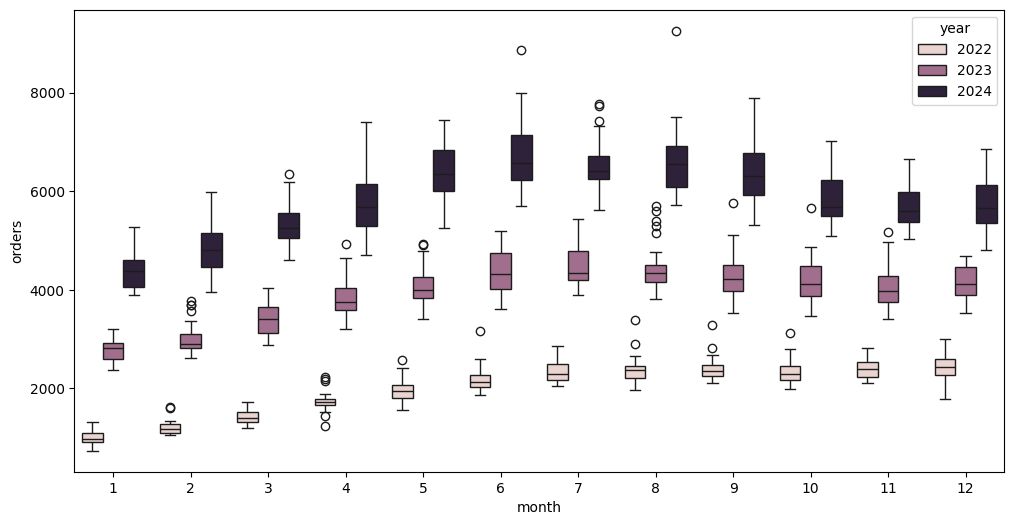

In [30]:
plt.figure(figsize=(12, 6))

sns.boxplot(
    data=df,
    x='month',
    y='orders',
    hue='year'
)

<Axes: xlabel='month', ylabel='gmv'>

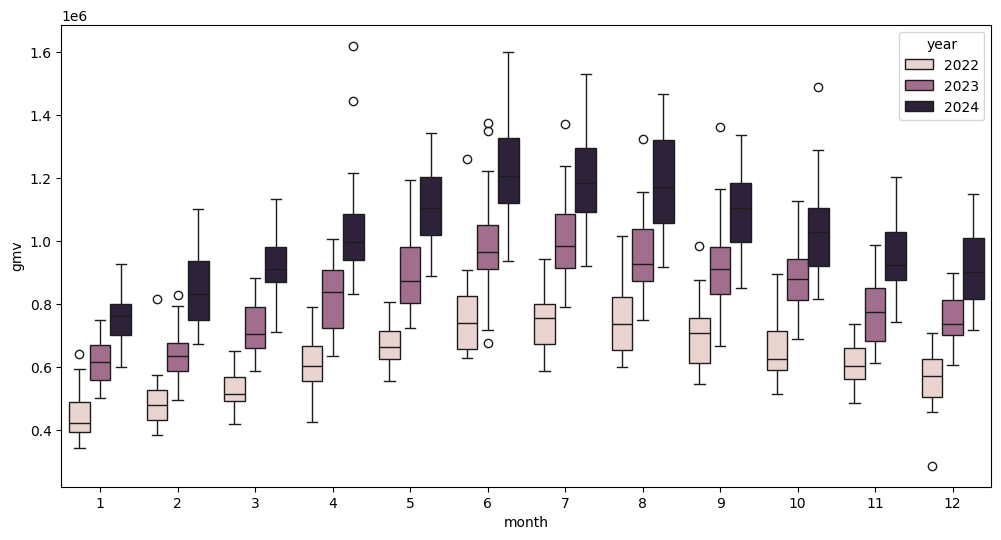

In [31]:
plt.figure(figsize=(12, 6))

sns.boxplot(
    data=df,
    x='month',
    y='gmv',
    hue='year'
)

## Под новый год спад gmv немного амортизируется, а количество заказов даже чуть вырастает

In [32]:
import holidays

ru_holidays = holidays.Russia(years=[2022, 2023, 2024])
df['is_holiday'] = df.index.isin(ru_holidays.keys())

/tmp/ipykernel_3213/1224109800.py:4: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df['is_holiday'] = df.index.isin(ru_holidays.keys())


## Для модели будет лучше подавать месяцы в цикличном виде, чтобы она понимала, что за декабрём сразу идёт январь

In [33]:
df['month_cos'] = np.cos(2 * np.pi * (df['month'] - 1) / 12)

In [34]:
df['day_of_month'] = df.index.day

## Добавим столбец с инфой о предудщих днях

In [35]:
lags = [1, 2, 3, 7, 14, 30]

for lag in lags:
    df[f'gmv_lag {lag}'] = df['gmv'].shift(lag)
    df[f'orders_lag {lag}'] = df['orders'].shift(lag)

## Добавим скользящие окна для выявления 7-дневных паттернов

In [36]:
df['gmv_window_mean'] = df['gmv'].rolling(window=7).mean().shift(1)
df['gmv_window_std'] = df['gmv'].rolling(window=7).std().shift(1)

df['orders_window_mean'] = df['orders'].rolling(window=7).mean().shift(1)
df['orders_window_std'] = df['orders'].rolling(window=7).std().shift(1)

## Добавим признаки, отражающие скорость изменения тренда

In [37]:
df["gmv_diff_1"] = df["gmv"] - df["gmv"].shift(1)
df["gmv_diff_7"] = df["gmv"] - df["gmv"].shift(7)
df["orders_diff_1"] = df["orders"] - df["orders"].shift(1)
df["orders_diff_7"] = df["orders"] - df["orders"].shift(7)

## Надо заполнить пропуски, появившиеся от сдвигов

In [38]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

cols = df.columns
index = df.index

scaler = StandardScaler()
scaled_df = scaler.fit_transform(df)

imputer = KNNImputer(weights='distance')
imputed_df = imputer.fit_transform(scaled_df)

df_result = scaler.inverse_transform(imputed_df)
df = pd.DataFrame(df_result, columns=cols, index=index)

## Выберем и обучим модель

## Для прогнозирования двух таргетов на 7 дней вперёд выберем простой метод: обучим 2 регрессора, которые будут выдавать предсказания на 1 день вперёд 7 раз

In [39]:
from lightgbm import (
    LGBMRegressor
)
from sklearn.metrics import (
    mean_absolute_percentage_error
)
from sklearn.model_selection import (
    TimeSeriesSplit
)
import optuna

## Для временных рядов надо следить, чтобы в обучающую выборку не попали данные из будущего, поэтому для тестовой выборки берём только последние дни, а вместо KFold кросс-валидации используем TimeSeriesSplit

In [40]:
split_index = df.index[-60]
train = df.loc[:split_index - pd.Timedelta(days=1)]
test = df.loc[split_index:]

X_train, y_train = train.drop(columns=['gmv', 'orders']), train['gmv']
X_test, y_test = test.drop(columns=['gmv', 'orders']), test['gmv']

## Кто-то говорит, что для бустинга не нужно OneHot-кодирование, кто-то говорит, что с ним ветвление лучше. Посмотрим, что лучше

## Без OneHot

In [ ]:
def objective(trial):
    params = {
        "learning_rate":    trial.suggest_loguniform("learning_rate", 1e-2, 2e-1),
        "max_iter":         trial.suggest_int("max_iter", 100, 500),
        "max_leaf_nodes":   trial.suggest_categorical("max_leaf_nodes", [15, 31, 63, 127]),
        "max_depth":        trial.suggest_int("max_depth", 3, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "l2_regularization": trial.suggest_loguniform("l2_regularization", 1e-3, 1e1),
    }
    
    model = LGBMRegressor(varbose=-1, **params)

    tscv = TimeSeriesSplit(test_size=7)
    mape_scores = []
    
    X = df.drop(columns=['gmv', 'orders'])
    y = df['gmv']
    
    for train_idx, val_idx in tscv.split(df):        
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
        
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        mape_scores.append(mean_absolute_percentage_error(y_val, preds))
    
    return np.mean(mape_scores)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=500, timeout=600)

print(study.best_params)
print(study.best_value)

## С OneHot

In [ ]:
def objective(trial):
    params = {
        "learning_rate":    trial.suggest_loguniform("learning_rate", 1e-2, 2e-1),
        "max_iter":         trial.suggest_int("max_iter", 100, 500),
        "max_leaf_nodes":   trial.suggest_categorical("max_leaf_nodes", [15, 31, 63, 127]),
        "max_depth":        trial.suggest_int("max_depth", 3, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "l2_regularization": trial.suggest_loguniform("l2_regularization", 1e-3, 1e1),
    }
    
    model = LGBMRegressor(varbose=-1, **params)

    tscv = TimeSeriesSplit(test_size=7)
    mape_scores = []
    
    X = df.drop(columns=['gmv', 'orders'])
    y = df['gmv']
    
    for train_idx, val_idx in tscv.split(df):        
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
        
        model.fit(X_train, y_train, categorical_feature='day_of_week')
        preds = model.predict(X_val)
        mape_scores.append(mean_absolute_percentage_error(y_val, preds))
    
    return np.mean(mape_scores)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=500, timeout=600)

print(study.best_params)
print(study.best_value)

## Для оценки предсказаний на 7 дней вперёд будем делать предсказания по тестовой выборке, будто каждый рассматриваемый день был последним

In [42]:
from datetime import timedelta

def make_features(current_date, df_full):
    row = df_full.loc[[current_date]].copy()
    row = row.drop(columns=['gmv', 'orders'])
    
    return row

def predict_7_days(model, df_history, df_full):
    
    df_pred = df_history.copy()
    
    preds = []
    
    last_known_date = df_pred.index.max()
    
    for step in range(1, 7 + 1):
        current_date = last_known_date + timedelta(days=step)
        
        X_h = make_features(current_date, df_full)
        
        gmv_pred = model.predict(X_h)[0]
        
        preds.append({
            'date' : current_date,
            'gmv' : gmv_pred
        })
        
        new_row = X_h.copy()
        new_row['gmv'] = gmv_pred
        
        df_pred = pd.concat([df_pred, new_row], axis=0)
    
    df_forecast = pd.DataFrame(preds).set_index('date')
    return df_forecast


In [43]:
def full_test(model, df, test_size=60):
    all_dates = df.index
    test_start = all_dates[-test_size]
    dates_test = all_dates[all_dates.get_loc(test_start) : -7]
    
    errors = []
    df_full = df.copy()
    
    for t in dates_test:
        df_hist = df.loc[:t].copy()
        
        predict_7d = predict_7_days(model, df_hist, df_full)
        
        actual = df.loc[predict_7d.index, 'gmv']
        errors.append(mean_absolute_percentage_error(actual, predict_7d))
        
    
    return np.mean(errors), np.std(errors)

full_test(model_gmv, df)

(np.float64(0.02635045052972402), np.float64(0.007294317975446838))

## Ошибка MAPE в 20-30 процентов является приемлемой, хоть и не хватающей звёзд с неба, как 10-20 процентов, насколько мне известно

## Для визуализации того, как отличаются предсказания от фактических значений построим графики отдельно для каждого дня недели
### Для этого изменим функцию тестирования

In [135]:
def predict_7_days(model, df_history, df_full):
    
    df_pred = df_history.copy()
    
    preds = []
    
    last_known_date = df_pred.index.max()
    
    for step in range(1, 7 + 1):
        current_date = last_known_date + timedelta(days=step)
        
        X_h = make_features(current_date, df_full)
        
        gmv_pred = model.predict(X_h)[0]
        
        preds.append({
            'date' : current_date,
            'gmv' : gmv_pred
        })
        
        new_row = X_h.copy()
        new_row['predicted_gmv'] = gmv_pred
        
        df_pred = pd.concat([df_pred, new_row], axis=0)
    
    df_forecast = pd.DataFrame(preds).set_index('date')
    df_forecast['day_for_pred'] = current_date
    return df_forecast


In [152]:
def full_test(model, df, test_size=60):
    all_dates = df.index
    test_start = all_dates[-test_size]
    dates_test = all_dates[all_dates.get_loc(test_start) : -7]
    
    errors = []
    df_full = df.copy()
    day_for_preds = []
    
    for t in dates_test:
        df_hist = df.loc[:t].copy()
        
        predict_7d = predict_7_days(model, df_hist, df_full)
        
        day_for_preds.append(predict_7d)
        
        actual = df.loc[predict_7d.index, 'gmv']
        errors.append(mean_absolute_percentage_error(actual, predict_7d['gmv']))
    
    return np.mean(errors), np.std(errors), pd.concat(day_for_preds)

mean, std, day_for_preds = full_test(model_gmv, df)
# day_for_preds.reset_index(inplace=True)

In [153]:
day_for_preds = day_for_preds.join(df['gmv'], how='inner', lsuffix='_pred', rsuffix='_actual').reset_index()
day_for_preds['day_for_pred'] = day_for_preds['day_for_pred'].dt.weekday
day_for_preds.set_index(['day_for_pred', 'date'], inplace=True)

In [155]:
day_for_preds

gmv_pred  gmv_actual
day_for_pred date                                
4            2024-11-02  1.079292e+06   1069184.0
             2024-11-03  9.728646e+05   1028366.0
             2024-11-04  9.093578e+05    898697.0
             2024-11-05  8.961111e+05    907865.0
             2024-11-06  9.178525e+05    888361.0
...                               ...         ...
0            2024-12-26  9.631646e+05    891794.0
             2024-12-27  1.073183e+06   1011484.0
             2024-12-28  1.098751e+06   1064332.0
             2024-12-29  1.141444e+06   1150266.0
             2024-12-30  7.753264e+05    775562.0

[371 rows x 2 columns]

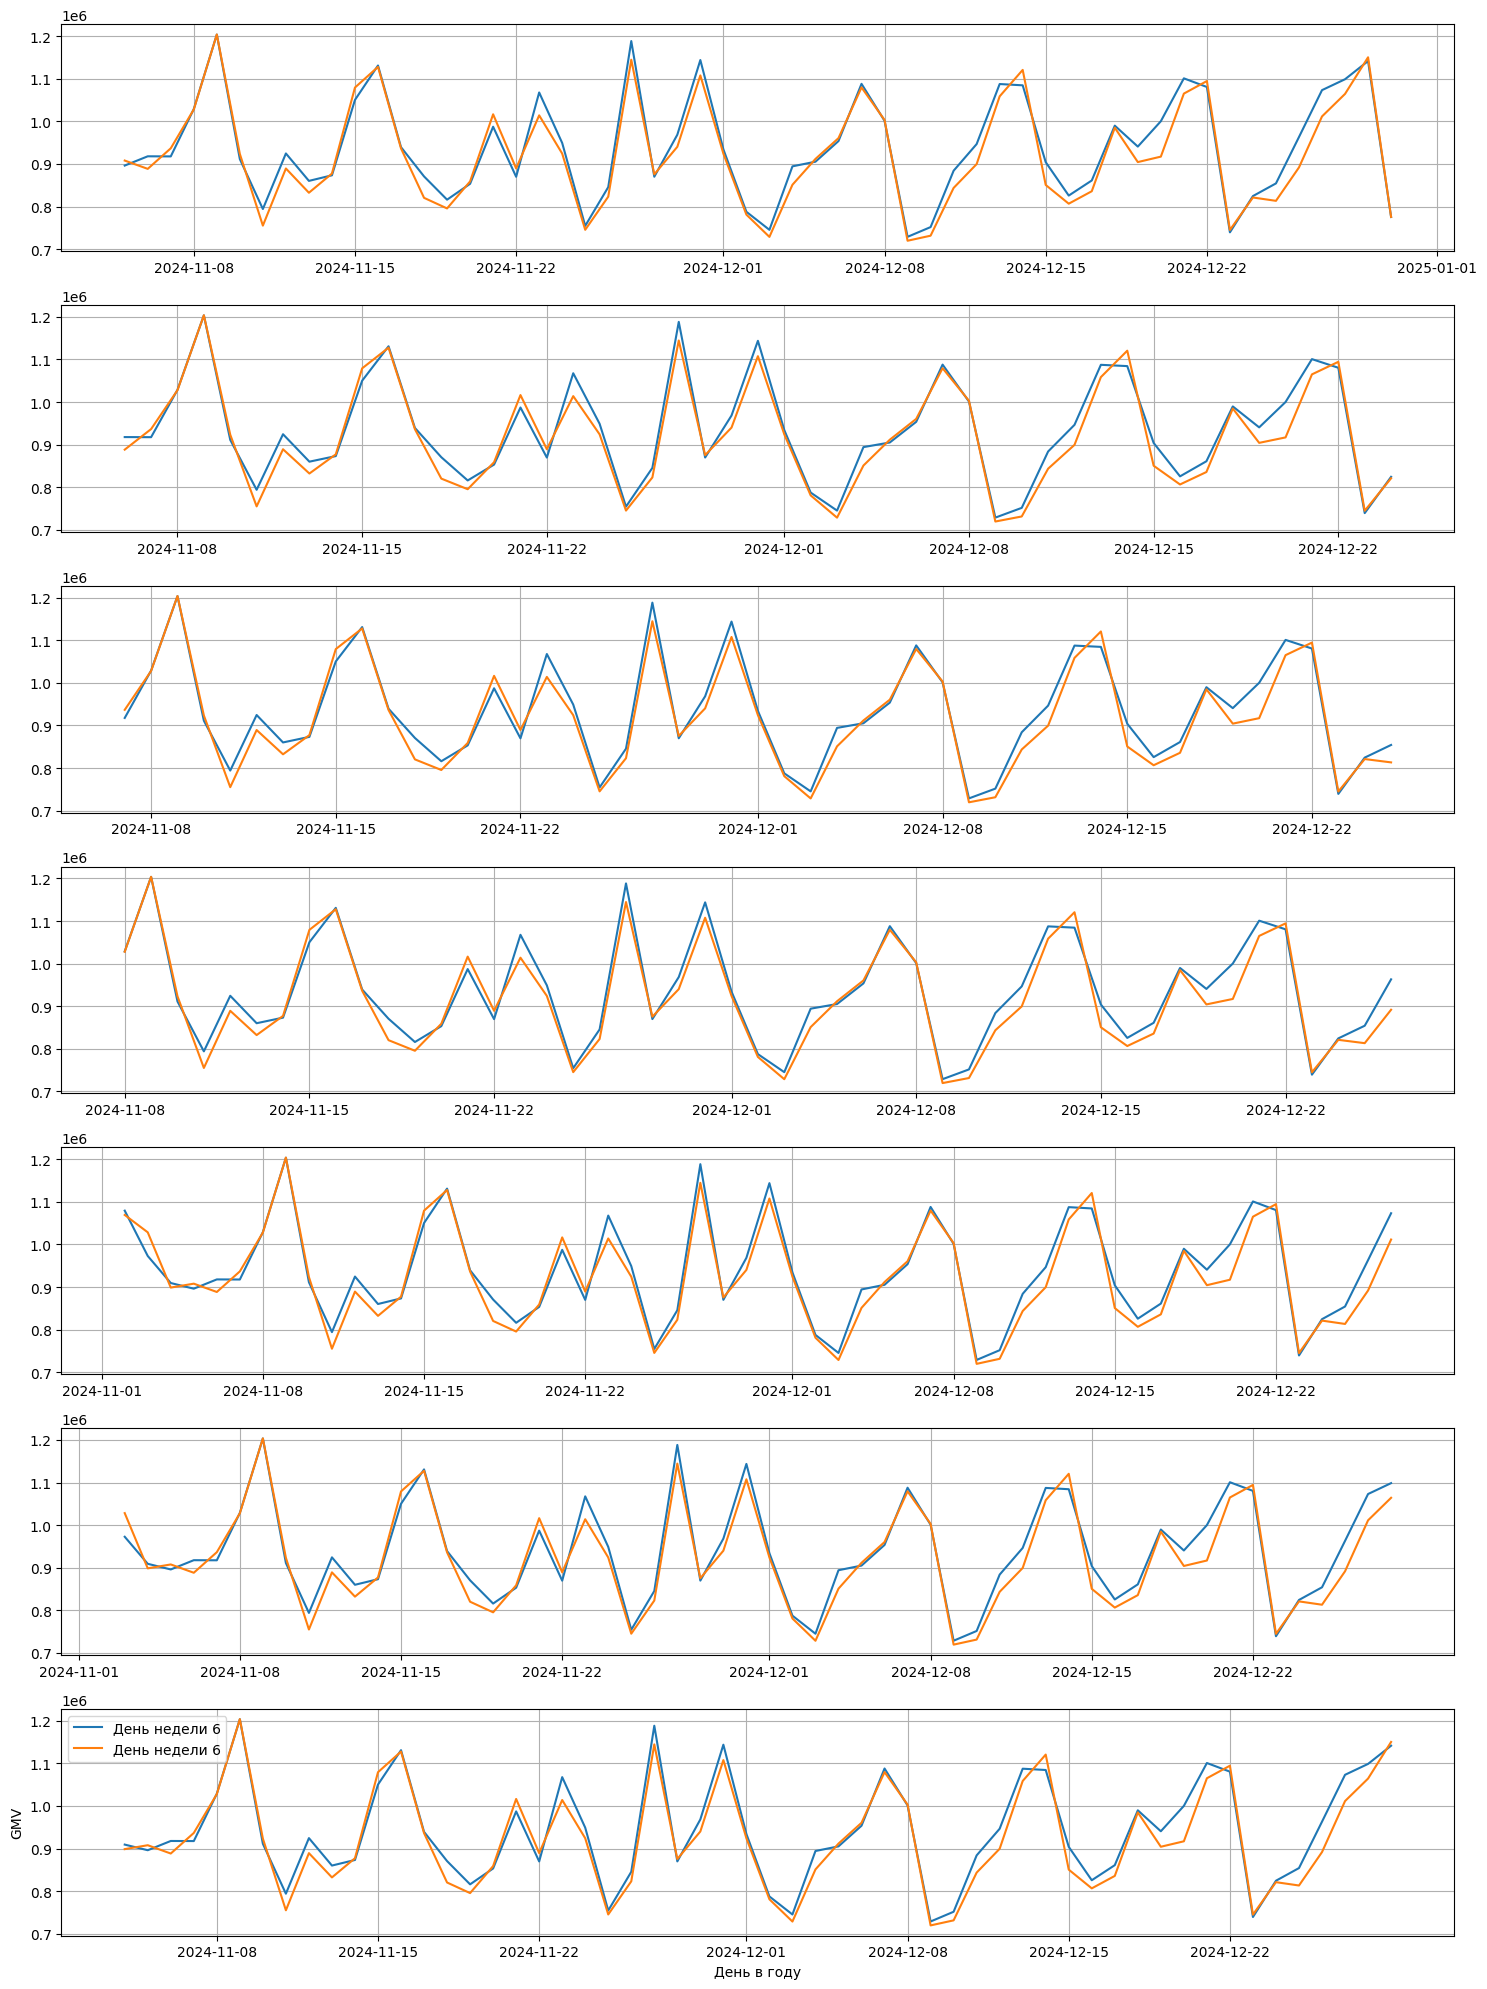

In [169]:
fig, axs = plt.subplots(7, 1, figsize=(15, 20))

weekdays = range(7)

for i, weekday in enumerate(weekdays):
    ax = axs[i]
    sub = day_for_preds.xs(weekday, level=0)
    ax.plot(
        sub.index.get_level_values(0),
        sub.gmv_pred,
        label=f'День недели {i}'
    )
    
    ax.plot(
        sub.index.get_level_values(0),
        sub.gmv_actual,
        label=f'День недели {i}'
    )
    
    ax.grid()

plt.xlabel('День в году')
plt.ylabel('GMV')
plt.legend()
plt.tight_layout()
plt.show()

## То же самое для orders

In [175]:
split_index = df.index[-60]
train = df.loc[:split_index - pd.Timedelta(days=1)]
test = df.loc[split_index:]

X_train, y_train = train.drop(columns=['gmv', 'orders']), train['orders']
X_test, y_test = test.drop(columns=['gmv', 'orders']), test['orders']

## Без OneHot

In [170]:
def objective(trial):
    params = {
        "learning_rate":    trial.suggest_loguniform("learning_rate", 1e-2, 2e-1),
        "max_iter":         trial.suggest_int("max_iter", 100, 500),
        "max_leaf_nodes":   trial.suggest_categorical("max_leaf_nodes", [15, 31, 63, 127]),
        "max_depth":        trial.suggest_int("max_depth", 3, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "l2_regularization": trial.suggest_loguniform("l2_regularization", 1e-3, 1e1),
    }
    
    model = LGBMRegressor(varbose=-1, **params)

    tscv = TimeSeriesSplit(test_size=7)
    mape_scores = []
    
    X = df.drop(columns=['gmv', 'orders'])
    y = df['orders']
    
    for train_idx, val_idx in tscv.split(df):        
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
        
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        mape_scores.append(mean_absolute_percentage_error(y_val, preds))
    
    return np.mean(mape_scores)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=500, timeout=600)

print(study.best_params)
print(study.best_value)

[I 2025-07-11 02:39:51,277] A new study created in memory with name: no-name-7bb54cbc-d8a9-4ffa-afd3-9dc1f67ed276
/tmp/ipykernel_3213/2766110079.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate":    trial.suggest_loguniform("learning_rate", 1e-2, 2e-1),
/tmp/ipykernel_3213/2766110079.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_regularization": trial.suggest_loguniform("l2_regularization", 1e-3, 1e1),
[I 2025-07-11 02:39:55,844] Trial 0 finished with value: 0.023950010465140857 and parameters: {'learning_rate': 0.014134679691520763, 'max_iter': 448, 'max_leaf_nodes': 31, 'max_depth': 7, 'min_samples_leaf': 17, 'l2_regularization': 0.03707300

{'learning_rate': 0.15209487266290803, 'max_iter': 396, 'max_leaf_nodes': 127, 'max_depth': 3, 'min_samples_leaf': 11, 'l2_regularization': 0.003537715953813086}
0.013649064584210812


## C OneHot

In [ ]:
def objective(trial):
    params = {
        "learning_rate":    trial.suggest_loguniform("learning_rate", 1e-2, 2e-1),
        "max_iter":         trial.suggest_int("max_iter", 100, 500),
        "max_leaf_nodes":   trial.suggest_categorical("max_leaf_nodes", [15, 31, 63, 127]),
        "max_depth":        trial.suggest_int("max_depth", 3, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "l2_regularization": trial.suggest_loguniform("l2_regularization", 1e-3, 1e1),
    }
    
    model = LGBMRegressor(varbose=-1, **params)

    tscv = TimeSeriesSplit(test_size=7)
    mape_scores = []
    
    X = df.drop(columns=['gmv', 'orders'])
    y = df['orders']
    
    for train_idx, val_idx in tscv.split(df):        
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
        
        model.fit(X_train, y_train, categorical_feature='day_of_week')
        preds = model.predict(X_val)
        mape_scores.append(mean_absolute_percentage_error(y_val, preds))
    
    return np.mean(mape_scores)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=500, timeout=600)

print(study.best_params)
print(study.best_value)

[I 2025-07-11 02:57:18,482] A new study created in memory with name: no-name-9381724f-7c7e-4559-aa7a-db3dadcfecf0
/tmp/ipykernel_3213/608455614.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate":    trial.suggest_loguniform("learning_rate", 1e-2, 2e-1),
/tmp/ipykernel_3213/608455614.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_regularization": trial.suggest_loguniform("l2_regularization", 1e-3, 1e1),
[I 2025-07-11 03:05:37,722] Trial 0 finished with value: 0.023622108384633984 and parameters: {'learning_rate': 0.17584302388059694, 'max_iter': 418, 'max_leaf_nodes': 127, 'max_depth': 5, 'min_samples_leaf': 6, 'l2_regularization': 0.00203241382

{'learning_rate': 0.021022071647355502, 'max_iter': 410, 'max_leaf_nodes': 127, 'max_depth': 4, 'min_samples_leaf': 16, 'l2_regularization': 0.007881013808791684}
0.01975928737023146


In [ ]:
model_orders = LGBMRegressor(varbose=-1, **study.best_params)
model_orders.fit(X_train, y_train)

0.019404828631525005

In [177]:
from datetime import timedelta

def make_features(current_date, df_full):
    row = df_full.loc[[current_date]].copy()
    row = row.drop(columns=['gmv', 'orders'])
    
    return row

def predict_7_days(model, df_history, df_full):
    
    df_pred = df_history.copy()
    
    preds = []
    
    last_known_date = df_pred.index.max()
    
    for step in range(1, 7 + 1):
        current_date = last_known_date + timedelta(days=step)
        
        X_h = make_features(current_date, df_full)
        
        orders_pred = model.predict(X_h)[0]
        
        preds.append({
            'date' : current_date,
            'orders' : orders_pred
        })
        
        new_row = X_h.copy()
        new_row['orders_pred'] = orders_pred
        
        df_pred = pd.concat([df_pred, new_row], axis=0)
    
    df_forecast = pd.DataFrame(preds).set_index('date')
    return df_forecast

def full_test(model, df, test_size=60):
    all_dates = df.index
    test_start = all_dates[-test_size]
    dates_test = all_dates[all_dates.get_loc(test_start) : -7]
    
    errors = []
    df_full = df.copy()
    
    for t in dates_test:
        df_hist = df.loc[:t].copy()
        
        predict_7d = predict_7_days(model, df_hist, df_full)
        
        actual = df.loc[predict_7d.index, 'orders']
        errors.append(mean_absolute_percentage_error(actual, predict_7d))
        
    
    return np.mean(errors), np.std(errors)

full_test(model_orders, df)

(np.float64(0.020197615967868506), np.float64(0.004730618962338106))

## Визуализация

In [179]:
def predict_7_days(model, df_history, df_full):
    
    df_pred = df_history.copy()
    
    preds = []
    
    last_known_date = df_pred.index.max()
    
    for step in range(1, 7 + 1):
        current_date = last_known_date + timedelta(days=step)
        
        X_h = make_features(current_date, df_full)
        
        ord_pred = model.predict(X_h)[0]
        
        preds.append({
            'date' : current_date,
            'orders' : ord_pred
        })
        
        new_row = X_h.copy()
        new_row['predicted_gmv'] = ord_pred
        
        df_pred = pd.concat([df_pred, new_row], axis=0)
    
    df_forecast = pd.DataFrame(preds).set_index('date')
    df_forecast['day_for_pred'] = current_date
    return df_forecast

def full_test(model, df, test_size=60):
    all_dates = df.index
    test_start = all_dates[-test_size]
    dates_test = all_dates[all_dates.get_loc(test_start) : -7]
    
    errors = []
    df_full = df.copy()
    day_for_preds = []
    
    for t in dates_test:
        df_hist = df.loc[:t].copy()
        
        predict_7d = predict_7_days(model, df_hist, df_full)
        
        day_for_preds.append(predict_7d)
        
        actual = df.loc[predict_7d.index, 'orders']
        errors.append(mean_absolute_percentage_error(actual, predict_7d['orders']))
    
    return np.mean(errors), np.std(errors), pd.concat(day_for_preds)

mean, std, day_for_preds = full_test(model_orders, df)

In [181]:
day_for_preds = day_for_preds.join(df['orders'], how='inner', lsuffix='_pred', rsuffix='_actual').reset_index()
day_for_preds['day_for_pred'] = day_for_preds['day_for_pred'].dt.weekday
day_for_preds.set_index(['day_for_pred', 'date'], inplace=True)

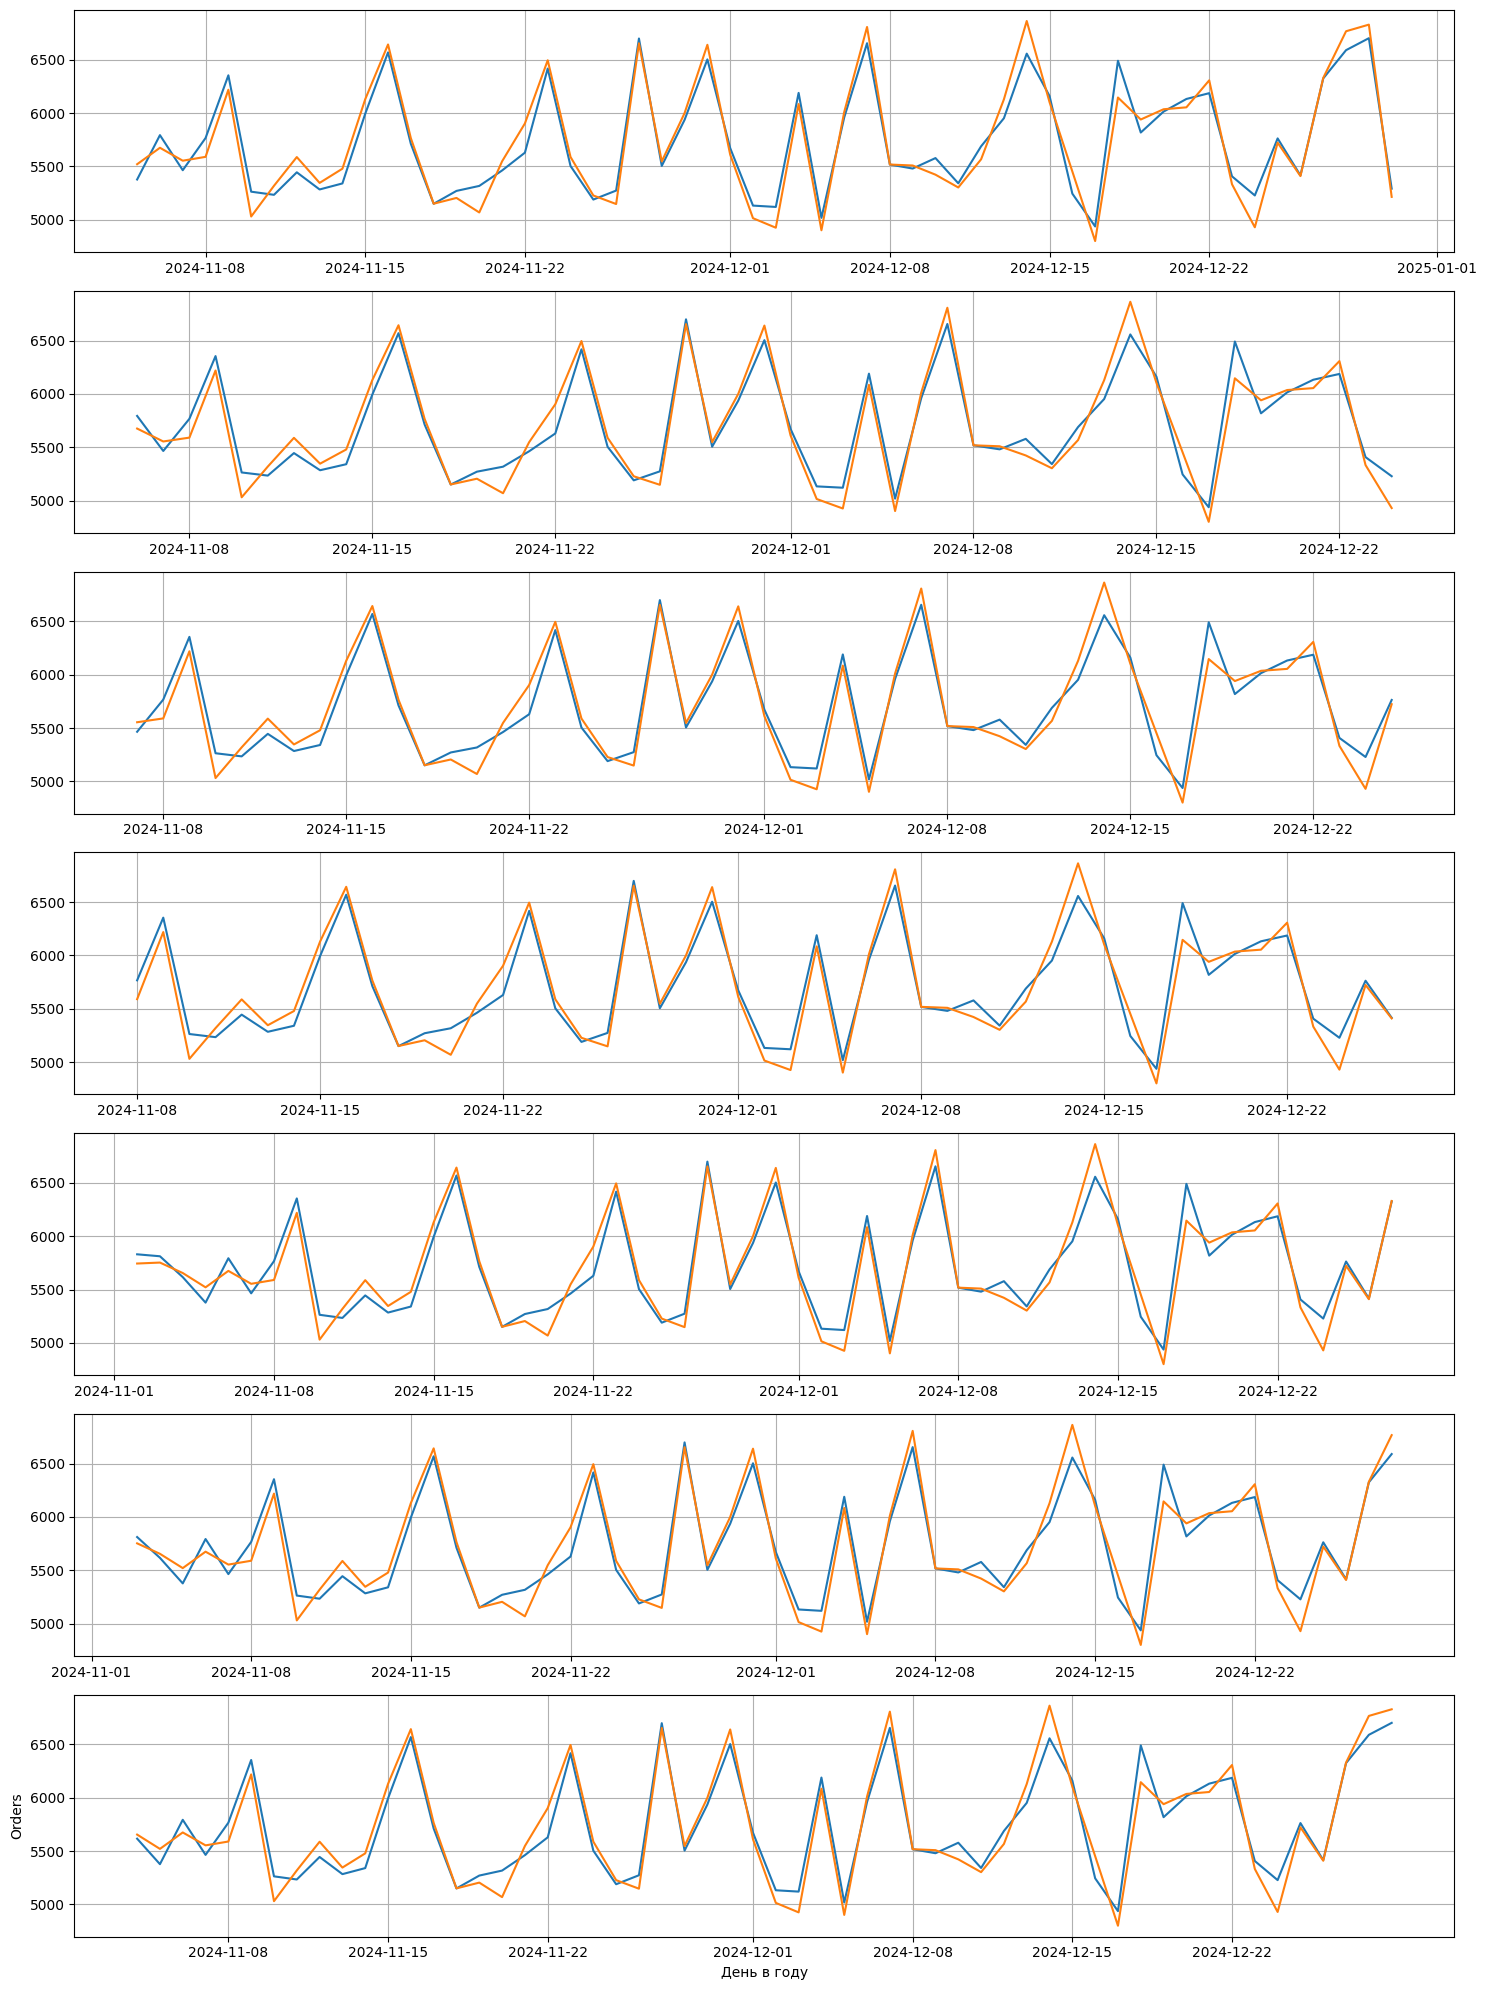

In [184]:
fig, axs = plt.subplots(7, 1, figsize=(15, 20))

weekdays = range(7)

for i, weekday in enumerate(weekdays):
    ax = axs[i]
    sub = day_for_preds.xs(weekday, level=0)
    ax.plot(
        sub.index.get_level_values(0),
        sub.orders_pred,
        label=f'День недели {i}'
    )
    
    ax.plot(
        sub.index.get_level_values(0),
        sub.orders_actual,
        label=f'День недели {i}'
    )
    
    ax.grid()

plt.xlabel('День в году')
plt.ylabel('Orders')
plt.tight_layout()
plt.show()